In [20]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
# pylint: enable=line-too-long
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, ADAM
from qiskit.opflow import TwoQubitReduction
from qiskit import BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit_nature.settings import settings
settings.dict_aux_operators = False

/opt/conda/envs/pennylane/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [161]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
molecule = Molecule(
    geometry=[
        ("Be",[0.0,0.0,0.0]),
        ("H", [0.0, 0.0, -1.3]),
        ("H", [0.0, 0.0, 1.3]),
    ],
    charge=0,
    multiplicity=1,
)
driver = PySCFDriver.from_molecule(molecule=molecule, basis="sto3g")


transformer = ActiveSpaceTransformer(
    num_electrons=4, # Number of electrons in our active space
    num_molecular_orbitals=4, # Number of orbitals in our active space
)
problem = ElectronicStructureProblem(
        driver,
        [transformer])

In [172]:
from circuit_knitting_toolbox.entanglement_forging import EntanglementForgingAnsatz
from qiskit.circuit.library import TwoLocal

ansatz = EntanglementForgingAnsatz(
    circuit_u=TwoLocal(4, [], "cry", [[0, 1], [0,2],[0,3],[1,2],[1,3],[2,3],
                                      [ 1,0], [2,0],[3,0],[2,1],[3,1],[3,2]], reps=1),
    bitstrings_u=[(1,1,1,0),(1,1,0,1),(1,0,1,1),(0,1,1,1),(1,1,0,0),(1,0,1,0),(1,0,0,1),(0,1,1,0),(0,1,0,1),(0,0,1,1)],
)

ansatz.circuit_u.draw()

»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌──────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                         ├
«     │                                                                          │
«q_1: ┤1                                                                         ├
«     │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) │
«q_2: ┤2                                                                         ├
«     │                                                                          │
«q_3: ┤3                                                                         ├
«     └──────────────────────────────────────────────────────────────────────────┘

In [173]:
from qiskit_ibm_runtime import QiskitRuntimeService, Options

# By default, use a local simulator to implement the Qiskit Runtime Primitives
service = None

# Uncomment the following line to instead use the Qiskit Runtime Service.
# service = QiskitRuntimeService(channel="ibm_quantum")

backend_names = ["ibmq_qasm_simulator"] * 4

# If a single set of options are passed, it will be applied to all backends
options = [Options(execution={"shots": 1000}), Options(execution={"shots": 2000}), Options(execution={"shots":2000}),Options(execution={"shots":1000})]

In [174]:
import numpy as np
from qiskit.algorithms.optimizers import COBYLA
from circuit_knitting_toolbox.entanglement_forging import (
    EntanglementForgingGroundStateSolver,
)

optimizer = COBYLA(maxiter=50,tol = 1e-5)

solver = EntanglementForgingGroundStateSolver(
    ansatz=ansatz,
    optimizer=optimizer,
    service=service,
    backend_names=backend_names,
    options=options,
    initial_point=[0.0, np.pi / 2,np.pi/2,np.pi/2, np.pi / 2,np.pi/2,np.pi/2, np.pi / 2,np.pi/2,np.pi/2, np.pi / 2,np.pi/2],
)

In [175]:
%%capture

results = solver.solve(problem)

Energy:


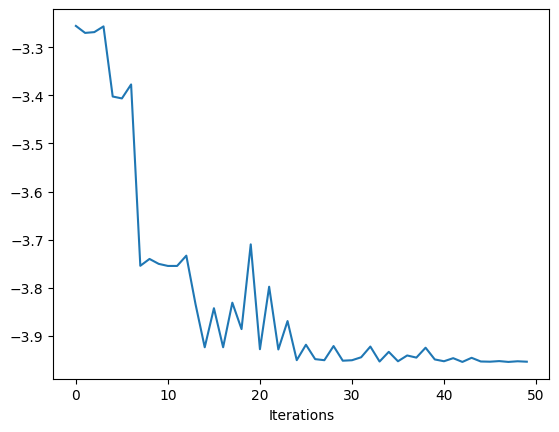

Schmidt Coefficients:


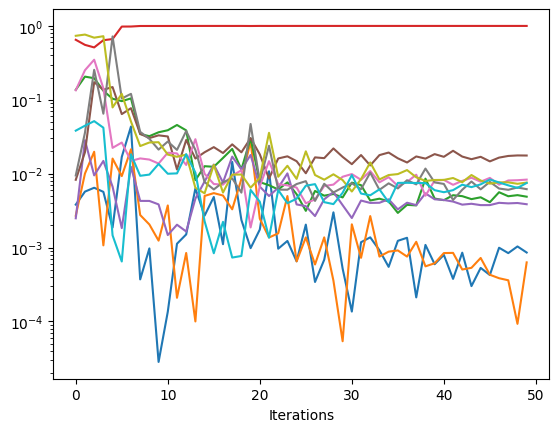

Parameters:


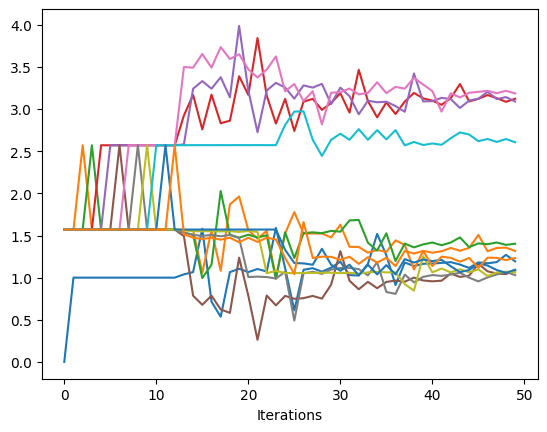

In [176]:
import matplotlib.pyplot as plt

print("Energy:")
plt.plot([evaluation.eigenvalue for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()

print("Schmidt Coefficients:")
plt.plot([abs(evaluation.eigenstate) for evaluation in results.history])
plt.xlabel("Iterations")
plt.yscale("log")
plt.show()

print("Parameters:")
plt.plot([evaluation.parameters for evaluation in results.history])
plt.xlabel("Iterations")
plt.show()